## Exploratory Data Anaylsis

File downloaded from:
https://www.kaggle.com/competitions/seti-breakthrough-listen/data/train/0/0000799a2b2c42d.npy

In [2]:
# !pip install plotly

In [3]:
import os
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir, path
import plotly.express as px
from sklearn.decomposition import NMF

import cv2 as cv

Load training data.

In [4]:
data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_df = pd.read_csv(os.path.join(data_dir, '_labels.csv'), delimiter=',')

In [5]:
def get_image_path(data_directory, file_id):
    path = os.path.join(data_directory, file_id[0], f'{file_id}.npy')

    return path

In [1]:
data_df = labels_df.copy()

data_df['file_path'] = labels_df['id'].apply(lambda x: get_image_path(data_dir, x))

NameError: name 'labels_df' is not defined

In [8]:
data_df.head()

,id,target,file_path
0,0000799a2b2c42d,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
1,00042890562ff68,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
2,0005364cdcb8e5b,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
3,0007a5a46901c56,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
4,0009283e145448e,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...


In [9]:
negative_samples = data_df.query('target == 0').sample(n=500)
positive_samples = data_df.query('target == 1').sample(n=500)

train_data_df = negative_samples.append(positive_samples)

C:\Users\adnan\AppData\Local\Temp\ipykernel_9340\1874693528.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data_df = negative_samples.append(positive_samples)


Locate a positive sample so that it can be visualised:

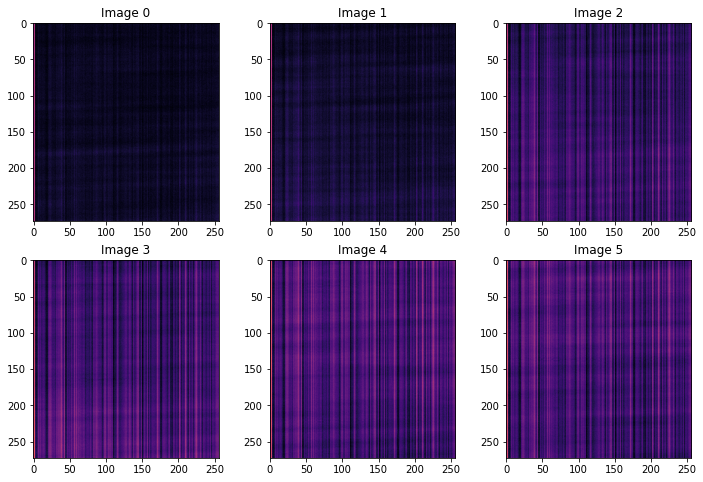

In [10]:
positive_sample = train_data_df[train_data_df.target == 1].iloc[12]
positive_sample_images = np.load(positive_sample['file_path']).astype(np.float32)

f, ax = plt.subplots(2, 3, figsize=(12,8))

for i in range(len(positive_sample_images)):
    row = i // 3
    column = i - row * 3

    ax[row, column].set_title('Image ' + str(i))
    ax[row, column].imshow(positive_sample_images[i], cmap=plt.get_cmap('magma'))

Each data file is a collection of spectograms. There is one spectogram for each 6 stars observed in the sequence **ABACAD**.
Where A is the target star and the rest are nearby off target stars.

### 1st place background noise reduction technique

1. Normalise per column
2. Calculate mean pixel difference of first column to all other images and columns
3. Some column distances are greater than 0 due to possible signals or rounding errors
4. Utilise overlaps to boost S:N ratio, by replacing original data with difference of normed regions between multiple matched samples.
5. Induces shadowing, where difference is <<0, from signals in matched samples. Which models can distinguish from actual signals.

## Denoising approach

Subtract off target images from on target ones.
Decompose images and reconstruct to get noise matrix. Subtract this from on target images.

https://www.kaggle.com/code/manabendrarout/rfi-reduction-ideas-examples-seti/notebook

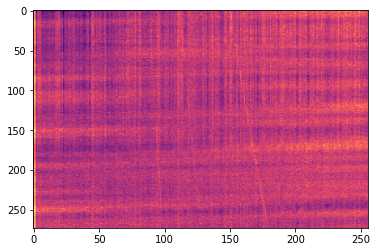

In [11]:
def normalise_image(image):
    image_min = image.min()
    image_max = image.max()

    return (image - image_min) / (image_max - image_min)


def get_decomposition_matrices(image):
    model = NMF(n_components=2, init='random', random_state=0)
    W = model.fit_transform(image + 100) # add 100 to ensure no negative values
    H = model.components_

    return (W, H)


def get_denoised_image(sample_images):
    combined_on_images = None
    combined_off_images = None
    combined_denoised_image = None

    for i in range(0, len(sample_images), 2):
        on_target_image = sample_images[i]
        off_target_image = sample_images[i+1]

        on_W, on_H = get_decomposition_matrices(on_target_image)
        off_W, off_H = get_decomposition_matrices(off_target_image)
        denoised_image = normalise_image(on_target_image - np.matmul(on_W, off_H))

        combined_on_images = on_target_image if combined_on_images is None else combined_on_images + on_target_image
        combined_off_images = off_target_image if combined_off_images is None else combined_off_images + off_target_image
        combined_denoised_image = denoised_image if combined_denoised_image is None else combined_denoised_image + denoised_image

    return combined_denoised_image


denoised_image = get_denoised_image(positive_sample_images).astype(float)
plt.imshow(denoised_image, aspect='auto', interpolation='antialiased', cmap=plt.get_cmap('magma'))

## Difference between ON and OFF target images

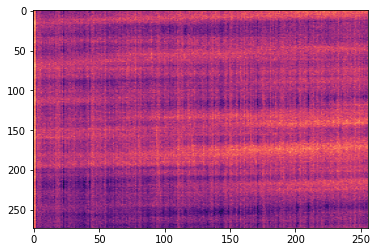

In [12]:
diff_image = positive_sample_images[0] - positive_sample_images[1] + positive_sample_images[2] - positive_sample_images[3] + positive_sample_images[4] - positive_sample_images[5]

plt.imshow(diff_image, aspect='auto', interpolation='antialiased', cmap=plt.get_cmap('magma'))

## Combination of denoising and difference techniques

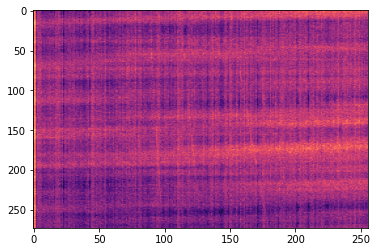

In [16]:
combined_denoised_image = denoised_image + diff_image

plt.imshow(combined_denoised_image, aspect='auto', interpolation='antialiased', cmap=plt.get_cmap('magma'))

# Subtracting negative samples from denoised image

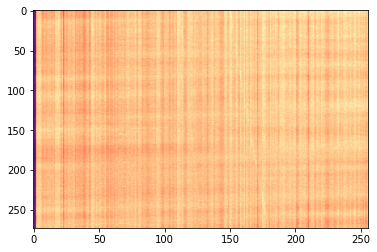

In [18]:
denoised_image_subtract_negative = denoised_image - (positive_sample_images[1] + positive_sample_images[3] + positive_sample_images[5]) / 3

plt.imshow(denoised_image_subtract_negative, aspect='auto', interpolation='antialiased', cmap=plt.get_cmap('magma'))